# Calculate mean of previously derived atmospheric clear-sky and all-sky heating rates from radiation fluxes

Import python backbone libraries:

In [1]:
import numpy as np
import xarray as xr
from pathlib import Path
import shutil
import zarr

In [2]:
from dask.distributed import Client
client = Client()
client

/pf/b/b380459/conda-envs/Nawdex-Hackathon/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35664 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:46325 Dashboard: http://127.0.0.1:35664/status,Cluster Workers: 6 Cores: 24 Memory: 134.22 GB


In [3]:
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [4]:
import sys
sys.path.append('/pf/b/b380459/nawdex-hackathon/')
import dict_nawdexsims

simdict   = dict_nawdexsims.simdictionary()
colordict = dict_nawdexsims.colordictionary()

In [5]:
def load_cellarea(gridres):
    path  = '/scratch/b/b380459/icon_4_hackathon/'
    dict_gridres={'80km': 'R80000m', '40km': 'R40000m', '20km': 'R20000m',
                  '10km': 'R10000m', '5km': 'R5000m', '2km': 'R2500m'}
    fname = path+'/grids/icon-grid_nawdex_78w40e23n80n_'+dict_gridres[gridres]+'.nc'
    return xr.open_dataset(fname)['cell_area'].rename({'cell': 'ncells'}) 

def load_openoceanmask(expid):
    path  = '/scratch/b/b380459/icon_4_hackathon/'
    fname = path+'/openocean_masks/'+expid+'_openoceanmask.nc'
    return xr.open_dataset(fname)['mask_openocean']

def load_data(sim):
    # open ocean mask
    da_oom = load_openoceanmask(sim)
    index  = np.where(da_oom==1)[0]
    # load data and only keep cells over open ocean
    da_cellarea = load_cellarea((simdict[sim])['res']).isel(ncells=index)
    zarr_store = '/scratch/b/b380459/icon_4_hackathon/'+sim+'/'+sim+'_ddttemp_rad-from-fluxes_DOM01_ML.zarr'
    ds_data = xr.open_zarr(zarr_store).isel(ncells=index)
    return ds_data, da_cellarea

In [ ]:
#for sim in list(simdict.keys()):
for sim in ['nawdexnwp-2km-mis-0005', 'nawdexnwp-2km-mis-0006', 'nawdexnwp-2km-mis-0007', 'nawdexnwp-2km-mis-0008',
            'nawdexnwp-2km-mis-0009', 'nawdexnwp-2km-mis-0010', 'nawdexnwp-2km-mis-0011', 'nawdexnwp-2km-mis-0012']:
    print('Working on', sim)
    ds, weights = load_data(sim)
    weights.name = "weights"
    temp_list = []
    for tstep in range(0,ds.time.size):
        temp_list.append(ds.isel(time=tstep).weighted(weights).mean('ncells').compute())
    ds_fldmean = xr.concat(temp_list, dim='time')
    ds_fldmean.to_netcdf('/scratch/b/b380459/icon_4_hackathon/atmradheating/'+
                         'atmradheating_fldmean_openocean_'+sim+'.nc')    

Working on nawdexnwp-2km-mis-0005


distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting

Plot domain time means

In [6]:
import matplotlib.pyplot as plt

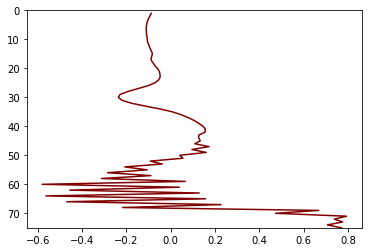

In [11]:
for sim in list(simdict.keys()):
    if ('shcon' not in sim) and simdict[sim]['start']=='20160922' and simdict[sim]['res']=='80km' and simdict[sim]['mphys']==1:
        ds = xr.open_dataset('/scratch/b/b380459/icon_4_hackathon/atmradheating/'+'atmradheating_fldmean_openocean_'+sim+'.nc')
        res = (simdict[sim])['res']
        color = colordict[res]
        plt.plot(86400*(ds['ddt_temp_radlw_fromflux']-ds['ddt_temp_radlwclr_fromflux']).mean('time'), ds.height, color=color)
        plt.ylim(75,0)

In [8]:
ds

<xarray.Dataset>
Dimensions:                     (height: 75, time: 97)
Coordinates:
  * height                      (height) float64 1.0 2.0 3.0 ... 73.0 74.0 75.0
  * time                        (time) datetime64[ns] 2016-10-13 ... 2016-10-17
Data variables:
    ddt_temp_radlw_fromflux     (time, height) float64 ...
    ddt_temp_radlwclr_fromflux  (time, height) float64 ...
    ddt_temp_radsw_fromflux     (time, height) float64 ...
    ddt_temp_radswclr_fromflux  (time, height) float64 ...